Project patch-wise features to 2D uMAP space

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import r_utils
from models import PredictionModel
from dataset import (
    CranberryPatchDataset, 
    DefaultSplitDescriptor, CoordSplitDescriptor, GenotypeSplitDescriptor,
)

from typing import Optional, Callable
import umap
import torch
import torch.functional as F
from transformers import AutoImageProcessor
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM
import importlib

importlib.reload(r_utils)

<module 'r_utils' from '/home/ronan/Documents/GitHub/breeders_aeye/ronan_work/r_utils.py'>

Load model and image processor:

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PredictionModel(
    backbone_name='facebook/dinov2-with-registers-base',
    # backbone_name='google/siglip2-base-patch16-224',
    # backbone_name='google/vit-base-patch16-224',
    prediction_heads = [],
    lora_options=None,
    do_normalization=True
).to(device)

# checkpoint_name = './checkpoints/fungicide_time/facebook_dinov2-with-registers-base_time_fungicide_10_epochs_21h34m.pth'
# checkpoint_name = './checkpoints/fungicide_heads/facebook_dinov2-with-registers-base_fungicide_10_epochs_20h34m.pth'
# checkpoint_name = './coord_split_checkpoints/facebook_dinov2-with-registers-base_time_fungicide_8_epochs_17h5m.pth'
# checkpoint_name = './checkpoints/geno_drop_test/google_vit-base-patch16-224_time_genotype_8_epochs_10h41m.pth'
# checkpoint_name = './new_split_checkpoints/facebook_dinov2-with-registers-base_genotype_time_8_epochs_0h0m.pth'

checkpoint_name = './checkpoints_pw/anis_genoB_split_dino.pth'
# checkpoint_name = './checkpoints_pw/l2.pth'
# checkpoint_name = './checkpoints_pw/d2-4.pth'
# checkpoint_name = './checkpoints_pw/r2.pth'
# checkpoint_name = './checkpoints_pw/h1.pth' # is this really patchwise? it uses a track split

model.load(checkpoint_name)

processor = AutoImageProcessor.from_pretrained(
    model.backbone_name,
    do_rescale=False,
    do_resize=False,
    use_fast=True
)

Loading from ./checkpoints_pw/anis_genoB_split_dino.pth


Prepare the dataset identically to how it was done when training the loaded checkpoint:

In [8]:
bog_2_patch_df = torch.load('prepped_data/bog_2_patches_p224_size_1344x2016.pt', weights_only=False) # 'p224' indicates that the patches are 224x224 pixels
dataset_locations = r_utils.load_toml('./dataset_locations.toml')
dataset = CranberryPatchDataset(bog_2_patch_df, dataset_locations)

# use the dataset split descriptor that was stored in the model checkpoint
data_splits = model.dataset_split_descriptor.split(dataset)
val_dataset = data_splits['test_dataset']
val_idxs = data_splits['test_idxs']

gen1 = torch.Generator().manual_seed(1)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, generator=gen1)

print(model.dataset_split_descriptor)

Splitting dataset by genotype
GenotypeSplitDescriptor(train_genotypes=['cnj12-30-24', 'cnj14-31-142', 'cnj05-73-39', 'cnj05-80-2', 'cnj06-22-10', 'cnj06-3-1'], test_genotypes=['cnj05-64-9', 'haines'])


Get the embedding:

In [9]:
@torch.no_grad()
def run_inference(model, processor, dataloader):
    model.eval()
    device = next(model.parameters()).device
    all_outputs = []

    print(f"Running inference on {device}")
    for patch, _ in tqdm(dataloader):
        if processor is not None:
            inputs = processor(patch, return_tensors='pt').to(device)
        else:
            inputs = {'pixel_values': patch.to(device)}
            
        outputs = model(inputs)['latent']
        all_outputs.append(outputs.cpu())

    return torch.cat(all_outputs, dim=0)

features = run_inference(model, processor, val_dataloader)

Running inference on cuda:0


100%|██████████| 248/248 [00:34<00:00,  7.27it/s]


In [10]:
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(features)

Plot the data

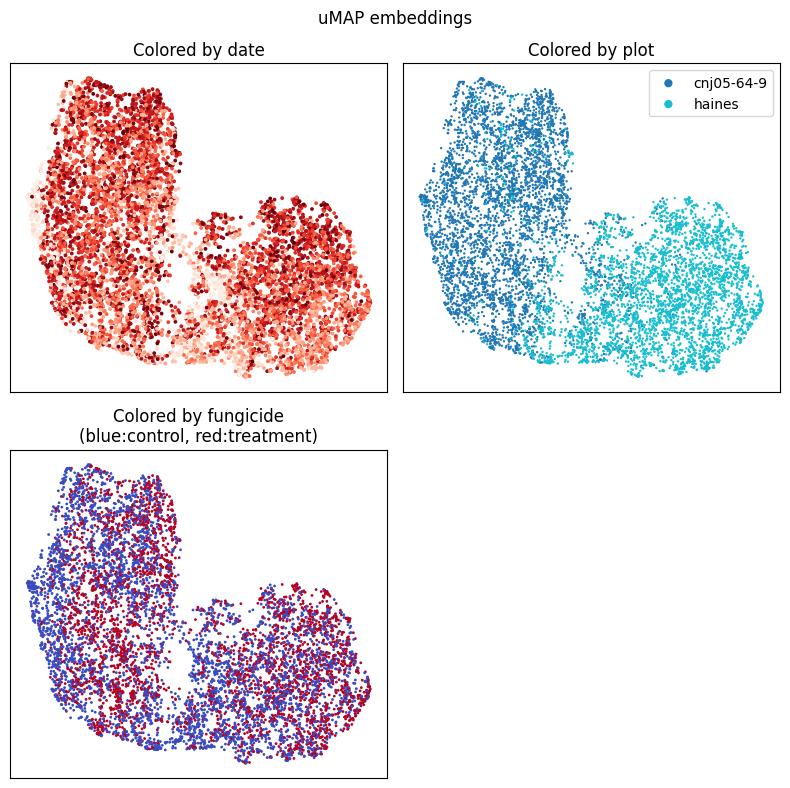

In [15]:
relevant_rows = bog_2_patch_df.iloc[val_idxs]

date_codes = relevant_rows['date'].astype('category').cat.codes
plot_codes = relevant_rows['plot'].astype('category').cat.codes
plot_labels = list(relevant_rows['plot'])
fungicide_codes = relevant_rows['fungicide'].astype('category').cat.codes

date_c, _ = r_utils.values_to_colors(list(date_codes), cmap_name='Reds')
plot_c, _ = r_utils.values_to_colors(list(plot_codes), cmap_name='tab10')
fungicide_c, fclist = r_utils.values_to_colors(list(fungicide_codes), cmap_name='coolwarm')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axs = axs.flatten()
axs[0].scatter(*embedding.T, s=3, c=date_c)
axs[0].set_title("Colored by date")


axs[1].set_title("Colored by plot")
for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    axs[1].scatter(
        embedding[i, 0], embedding[i, 1], label=label, s=0.5, c=np.array(plot_c)[i]
    )
l1 = axs[1].legend(markerscale=7)

axs[2].scatter(*embedding.T, s=1, c=fungicide_c)
axs[2].set_title("Colored by fungicide\n(blue:control, red:treatment)")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

axs[3].axis('off')

plt.suptitle("uMAP embeddings")
plt.tight_layout()
plt.show()

# Paper-ready plotting
Distinguish between unseen plant varieties

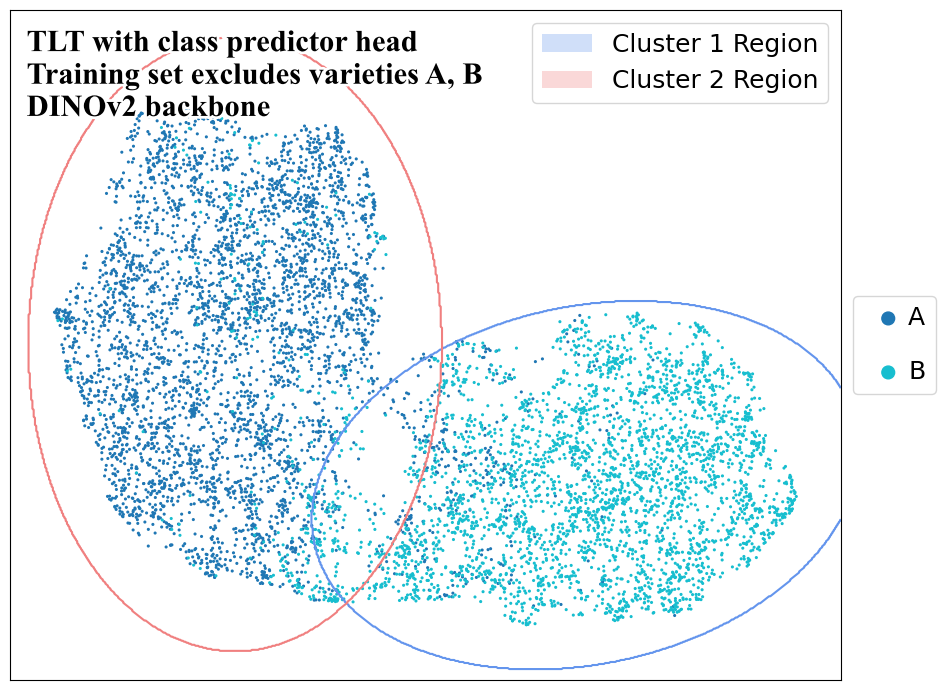

In [147]:
import matplotlib.patheffects as path_effects
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
from scipy.stats import chi2, multivariate_normal
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

witheld_genotypes = sorted([r_utils.var_to_letter[geno] for geno in model.dataset_split_descriptor.test_genotypes])

fig_scale=0.5
fig_size = (19*1.1, 14)
plt.figure(figsize=(fig_scale*fig_size[0],fig_scale*fig_size[1]), dpi=100) # dpi=300 for saved version

scatter_handles = []
for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    scatter_handle = plt.scatter(embedding[i, 0], embedding[i, 1], label=label, s=1.5, c=np.array(plot_c)[i], rasterized=True)
    scatter_handles.append(scatter_handle)

ax = plt.gca()
ax.text(
    0.02, 0.97,
    f'TLT with class predictor head\nTraining set excludes varieties {', '.join(witheld_genotypes)}\n' + \
    f'{r_utils.prettify_backbone_name(model.backbone_name)} backbone',
    transform=ax.transAxes,     
    fontsize=22,
    verticalalignment='top',
    fontname='Times New Roman',
    weight='bold',
    path_effects=[
        path_effects.Stroke(linewidth=4, foreground='white'),
        path_effects.Normal()
    ]
) 

# fit gmm and plot
n_components = len(witheld_genotypes)
gmm = GaussianMixture(n_components=n_components, random_state=0).fit(embedding)

# create grid for evaluation
x = np.linspace(embedding[:, 0].min() - 1, embedding[:, 0].max() + 1, 650)
y = np.linspace(embedding[:, 1].min() - 1, embedding[:, 1].max() + 1, 650)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.dstack((X_grid, Y_grid))

conf_level = 0.95
threshold = chi2.ppf(conf_level, df=2)

# plot confidence regions for each GMM component
colors = ['cornflowerblue', 'lightcoral', 'purple']
for i in range(n_components):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]

    # evaluate Mahalanobis distance (using PDF level threshold)
    rv = multivariate_normal(mean=mean, cov=cov)
    log_level = np.log(rv.pdf(mean)) - 0.5 * threshold
    region = rv.logpdf(pos) >= log_level
    ax.contour(X_grid, Y_grid, region, colors=[colors[i]])

contour_legend = [
    Patch(facecolor='cornflowerblue', edgecolor='none', alpha=0.3, label='Cluster 1 Region'),
    Patch(facecolor='lightcoral', edgecolor='none', alpha=0.3, label='Cluster 2 Region'),
    Patch(facecolor='purple', edgecolor='none', alpha=0.3, label='Cluster 3 Region')
]

# legend for the countours
contour_artist = ax.legend(
    handles=contour_legend[:n_components],
    fontsize=18,
    markerscale=5
)
ax.add_artist(contour_artist)

# legend for the scatterplot
ax.legend(
    handles=scatter_handles,
    labels=witheld_genotypes,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=18,
    markerscale=7.5,
    labelspacing=1.2,
    handletextpad=-0.2,
    # borderpad=0.0,
    # borderaxespad=2.0
)

ylims = ax.get_ylim()
ax.set_ylim(top=ylims[1]+0.4, bottom=ylims[0]+0.2)

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(left=0.1)
# plt.savefig('../media/umap_unseen_geno_rdots.svg')
plt.show()

Calculate the modified percent agreement (PA) metric:

In [39]:
component_wise_labels = gmm.predict(embedding)
pc_arr = np.array(plot_codes)
cluster_actual_classes = []

for i in range(n_components):
    class_code = np.argmax(np.bincount(pc_arr[np.where(component_wise_labels == i)]))
    actual_class = relevant_rows['plot'].astype('category').cat.categories[class_code]
    cluster_actual_classes.append(actual_class)

component_wise_labels_class = [cluster_actual_classes[i] for i in component_wise_labels]

agreements = np.sum(np.array(component_wise_labels_class) == np.array(plot_labels))

print(f'{agreements} / {len(component_wise_labels_class)}')
print(f'PA: {round(agreements/len(component_wise_labels_class),3)}%')

# print(cluster_actual_classes)

7262 / 7920
PA: 0.917%


Visualizations with images

**Note:** you may have to run this cell or the following cell twice to get the correct plot to show up

In [18]:
%matplotlib widget
import plotting_vis
from importlib import reload
reload(plotting_vis)

# take only a smaller subset of points to plot
k = 300
np.random.seed(3)
indices = np.random.choice(embedding.shape[0], size=k, replace=False, )

features_subset = np.array(embedding[indices])
rich_labels = relevant_rows[['plot', 'date', 'patch_coords', 'fungicide']].iloc[indices].to_dict(orient='list')

p_dev = torch.tensor(processor.image_std).view(3,1,1)
p_mean = torch.tensor(processor.image_mean).view(3,1,1)
images = [val_dataset[i][0] for i in indices]

plotting_vis.plot_with_annotations(features_subset, rich_labels['plot'], images, figsize=(7,7), cmap='tab10')
%matplotlib inline

In [12]:
print([l[160] for l in rich_labels.values()])
print([l[100] for l in rich_labels.values()])


['cnj12-30-24', datetime.date(2024, 6, 26), array([2, 6]), 'control']
['haines', datetime.date(2024, 9, 6), array([2, 4]), 'control']


# Compare Heads Figure

In [2]:
from r_utils import run_inference
import matplotlib.patheffects as path_effects


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PredictionModel(
    backbone_name='facebook/dinov2-with-registers-base',
    prediction_heads = [],
    lora_options=None,
    do_normalization=True
).to(device)

checkpoint_name = './checkpoints_pw/m1.pth'
# checkpoint_name = './checkpoints_pw/d2-4.pth'

model.load(checkpoint_name)

processor = AutoImageProcessor.from_pretrained(
    model.backbone_name,
    do_rescale=False,
    do_resize=False,
    use_fast=True
)

Loading from ./checkpoints_pw/m1.pth


In [3]:
bog_2_patch_df = torch.load('prepped_data/bog_2_patches_p224_size_1344x2016.pt', weights_only=False) # 'p224' indicates that the patches are 224x224 pixels
dataset_locations = r_utils.load_toml('./dataset_locations.toml')
dataset = CranberryPatchDataset(bog_2_patch_df, dataset_locations)

# use the dataset split descriptor that was stored in the model checkpoint
data_splits = model.dataset_split_descriptor.split(dataset)
val_dataset = data_splits['test_dataset']
val_idxs = data_splits['test_idxs']

gen1 = torch.Generator().manual_seed(1)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, generator=gen1)

Splitting dataset by patch coordinates
Attempting to split the dataset with a 0.8/0.2 split. Actual split: 0.8/0.2.


In [5]:
features = run_inference(model, processor, val_dataloader)

Running inference on cuda:0


100%|██████████| 187/187 [00:24<00:00,  7.65it/s]


In [6]:
reducer = umap.UMAP(n_components=2, random_state=1, n_neighbors=4)
embedding = reducer.fit_transform(features)

In [8]:
relevant_rows = bog_2_patch_df.iloc[val_idxs]
plot_codes = relevant_rows['plot'].astype('category').cat.codes
plot_labels = list(relevant_rows['plot'])
plot_c, _ = r_utils.values_to_colors(list(plot_codes), cmap_name='tab10')

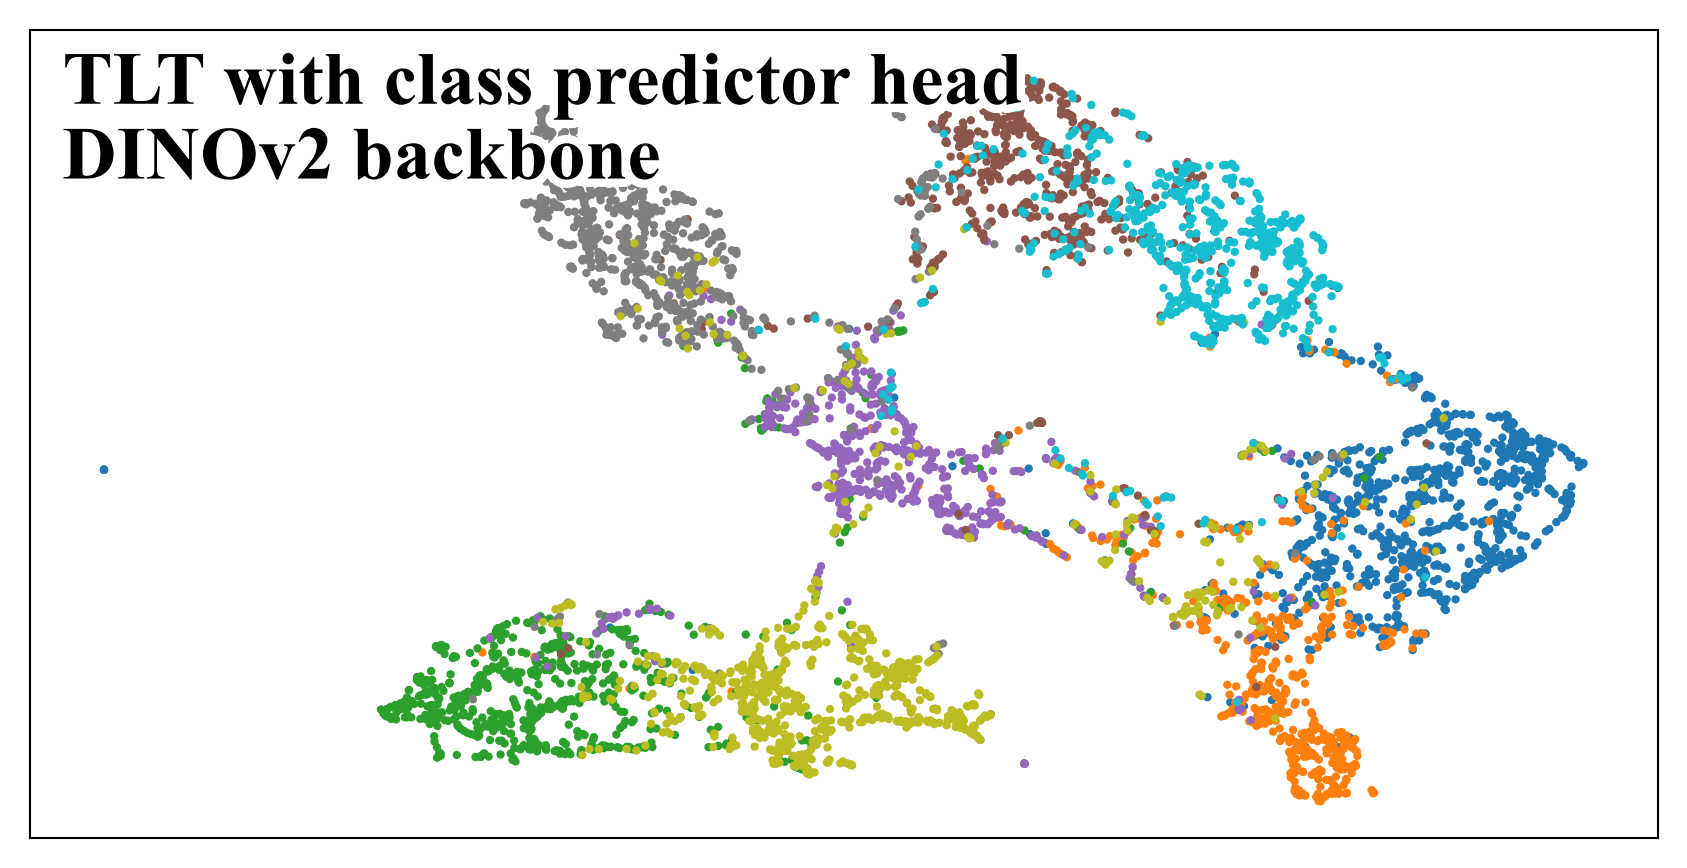

In [11]:
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 0.5
plt.rcParams['path.simplify'] = False

fig_scale=0.5
fig_size = (14, 7)
plt.figure(figsize=(fig_scale*fig_size[0],fig_scale*fig_size[1]), dpi=300) # dpi=300 for saved version

for label in np.unique(plot_labels):
    i = np.where(np.array(plot_labels) == label)
    plt.scatter(
        embedding[i, 0],
        embedding[i, 1],
        label=label,
        s=1,
        c=np.array(plot_c)[i],
        rasterized=True
    )

ax = plt.gca()
ax.text(
    0.02, 0.97,
    f'TLT with class predictor head\n'+ \
    f'{r_utils.prettify_backbone_name(model.backbone_name)} backbone',
    transform=ax.transAxes,     
    fontsize=18,
    verticalalignment='top',
    fontname='Times New Roman',
    weight='bold',
    path_effects=[
        path_effects.Stroke(linewidth=4, foreground='white'),
        path_effects.Normal()
    ]
)

# ylim = ax.get_ylim()
# ax.set_ylim((ylim[0], ylim[1]+2))

plt.xticks([])
plt.yticks([])
plt.savefig('../media/umap_cmp_heads_1.svg')
plt.show()

## GradCAM
Pick two points in latent space. Compare their higher dimensional features, backpropogate their differences to visualize how they are similar and different.

See `gc_example_but_hf.ipynb`

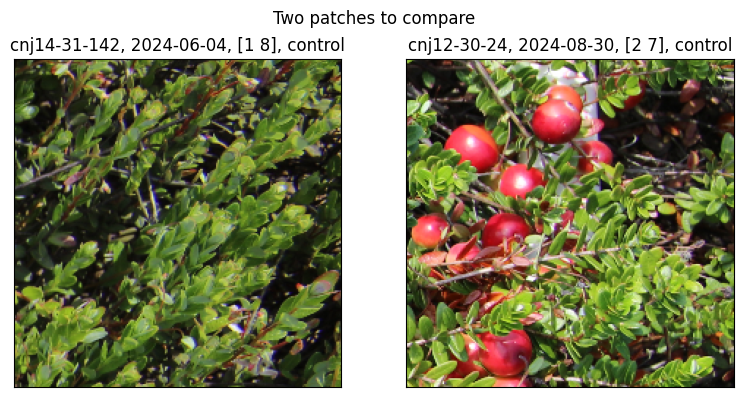

In [20]:
t0_idx = 100
t1_idx = 160

t0_img = images[t0_idx]
t1_img = images[t1_idx]

fig, axs = plt.subplots(ncols=2, figsize=(8,4))
axs[0].imshow(t0_img.numpy().transpose(1,2,0))
axs[1].imshow(t1_img.numpy().transpose(1,2,0))
axs[0].set_title(', '.join([str(l[t0_idx]) for l in rich_labels.values()]))
axs[1].set_title(', '.join([str(l[t1_idx]) for l in rich_labels.values()]))

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Two patches to compare")
plt.tight_layout()
plt.show()

In [21]:
import torch.functional as F
# from pytorch_grad_cam import GradCAM
import pytorch_grad_cam
reload(pytorch_grad_cam)
from pytorch_grad_cam import GradCAM

class HFFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(HFFeatureExtractor, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model({'pixel_values': x})['latent']

wrapped_model = HFFeatureExtractor(model)
wrapped_model.to(torch.device('cpu'))

for param in wrapped_model.parameters():
    param.requires_grad = True

n_registers = 4 if 'registers' in model.backbone_name else 0

In [22]:
t0_input = processor(t0_img, return_tensors='pt')
t1_input = processor(t1_img, return_tensors='pt')

t0_concept_feature = model(t0_input)['latent'][0].detach()
t1_concept_feature = model(t1_input)['latent'][0].detach()
print(t1_concept_feature.shape)

torch.Size([192])


In [23]:
class DissimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        loss_fn = torch.nn.CosineSimilarity(dim=0)
        # loss_fn = torch.nn.MSELoss()
        return 1 - loss_fn(model_output, self.features)
    
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        loss_fn = torch.nn.CosineSimilarity(dim=0)
        # loss_fn = torch.nn.MSELoss()
        return loss_fn(model_output, self.features)
    
def reshape_transform(tensor):
    w = int(np.sqrt(tensor.shape[1])) # assume all images are sqare
    result = tensor[:, 1+n_registers:  , :].reshape(tensor.size(0), w, w, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

if 'vit' in model.backbone_name:
    target_layer = wrapped_model.model.backbone.encoder.layer[-1].layernorm_before
else:
    target_layer = wrapped_model.model.backbone.encoder.layer[-1].norm1

# target_layer.requires_grad_()

concept_targets = [
    SimilarityToConceptTarget(t1_concept_feature),
    DissimilarityToConceptTarget(t1_concept_feature)
]

with GradCAM(model=wrapped_model, target_layers=[target_layer], reshape_transform=reshape_transform) as cam:
    cam = cam(
        input_tensor=t0_input['pixel_values'].repeat(len(concept_targets),1, 1, 1),
        targets=concept_targets
    )

fig, axs = plt.subplots(nrows=2, ncols=2)
w = cam.shape[1]
t0_img_np = t0_img.numpy().transpose(1,2,0)
t1_img_np = t1_img.numpy().transpose(1,2,0) #TODO check these transposes, i might have broke them

axs[0,0].imshow(t0_img_np)
axs[0,0].axis('off')
axs[0,0].set_title(r'$t_0$ image')
axs[0,1].imshow(t1_img_np)
axs[0,1].axis('off')
axs[0,1].set_title(r'$t_1$ image')

for i, ax in enumerate(axs[1]):
    ax.imshow(cv2.resize(t0_img_np, (w,w)))
    ax.imshow(cam[i], cmap='jet', alpha=0.5)
    ax.axis('off')

axs[1, 0].set_title(r'Similarities to $t_1$ concept')
axs[1, 1].set_title(r'Dissimilarities to $t_1$ concept')

plt.tight_layout()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [2, 768]], which is output 0 of AsStridedBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

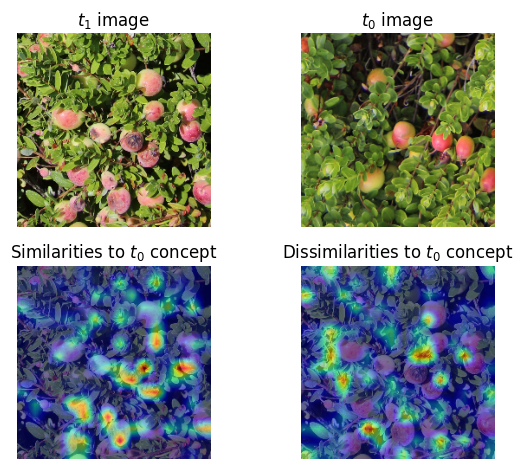

In [49]:
# concept_target = SimilarityToConceptTarget(t0_concept_feature)
concept_targets = [
    SimilarityToConceptTarget(t0_concept_feature),
    DissimilarityToConceptTarget(t0_concept_feature)
]

with GradCAM(model=wrapped_model, target_layers=[target_layer], reshape_transform=reshape_transform) as cam:
    cam = cam(
        input_tensor=t1_input['pixel_values'].repeat(len(concept_targets),1, 1, 1),
        targets=concept_targets
    )

fig, axs = plt.subplots(nrows=2, ncols=2)
w = cam.shape[1]
t0_img_np = t0_img.numpy().transpose(1,2,0)
t1_img_np = t1_img.numpy().transpose(1,2,0)

axs[0,0].imshow(t1_img_np)
axs[0,0].axis('off')
axs[0,0].set_title(r'$t_1$ image')
axs[0,1].imshow(t0_img_np)
axs[0,1].axis('off')
axs[0,1].set_title(r'$t_0$ image')

for i, ax in enumerate(axs[1]):
    ax.imshow(cv2.resize(t1_img_np, (w,w)))
    ax.imshow(cam[i], cmap='jet', alpha=0.5)
    ax.axis('off')

axs[1, 0].set_title(r'Similarities to $t_0$ concept')
axs[1, 1].set_title(r'Dissimilarities to $t_0$ concept')

plt.tight_layout()

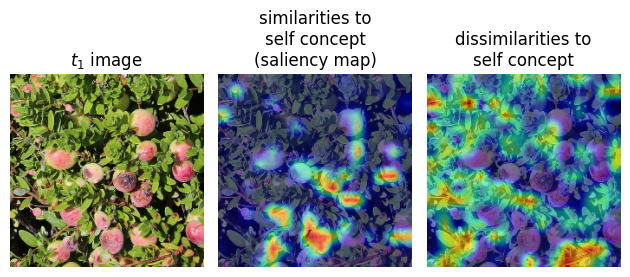

In [52]:
concept_targets = [
    SimilarityToConceptTarget(t1_concept_feature),
    DissimilarityToConceptTarget(t1_concept_feature)
]

with GradCAM(model=wrapped_model, target_layers=[target_layer], reshape_transform=reshape_transform) as cam:
    cam = cam(
        input_tensor=t1_input['pixel_values'].repeat(len(concept_targets),1, 1, 1),
        targets=concept_targets
    )

fig, axs = plt.subplots(ncols=3)
w = cam.shape[1]
t0_img_np = t0_img.numpy().transpose(1,2,0)
t1_img_np = t1_img.numpy().transpose(1,2,0)

axs[0].imshow(t1_img_np)
axs[0].axis('off')
axs[0].set_title(r'$t_1$ image')

axs[1].imshow(cv2.resize(t1_img_np, (w,w)))
axs[1].imshow(cam[0], cmap='jet', alpha=0.5)
axs[1].axis('off')
axs[1].set_title('similarities to\nself concept\n(saliency map)')

axs[2].imshow(cv2.resize(t1_img_np, (w,w)))
axs[2].imshow(cam[1], cmap='jet', alpha=0.5)
axs[2].axis('off')
axs[2].set_title('dissimilarities to\nself concept')

plt.tight_layout()